In [1]:
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, AdamW
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

import torch
import torch.nn.functional as F
import argparse
import os
from generation_utils import debias_vl_set, txt_process, bias_prompt, AttackTarget
from copy import deepcopy as dc
class Args:
    cls = "a photo of a waterbird"  # target class name
    lam = 100.0  # regularizer constant
    mode = "base"  # mode options: ['debias_vl', 'base', 'debias_vl_bias']
    use = "base"  # use options: ['debias_vl', 'base', 'fairerclip']
    revision = None  # Revision of pretrained model identifier from huggingface.co/models
    bias = "background"  # Bias type
    epochs = 100  # Number of epochs
    alpha = 0.3  # Alpha value
    pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1-base"  # Path to pretrained model
    config_file = "configs/debias_waterbird_mode.yaml"  # Path to config file
    model = "clip_ViTL14"  # Model type
    pretrained_vae_name_or_path = None  # Path to pretrained VAE

# Instantiate args
args = Args()
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
batch_size = 1
alpha = 0.3
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2-1-base"
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer" )
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder" )
text_encoder = text_encoder.to(torch_device)

target_model = AttackTarget(text_encoder, 1, torch_device).to(torch_device)
optimizer = AdamW(filter(lambda p: p.requires_grad, target_model.parameters()), lr=5e-5)
# peft tuning
sub = torch.tensor(0, device=torch_device).float()

candidate_prompt, S = debias_vl_set(args)
bias_prompt, S_bias = bias_prompt(two_prompt=False)
retain_prompt = ['a photo of a landbird.', 'a photo of a waterbird.']
cls_step = len(S) // len(retain_prompt)

/home/connor/.conda/envs/fair/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/connor/.conda/envs/fair/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [2]:

with torch.no_grad():
    z0 = txt_process(retain_prompt, text_encoder, tokenizer, torch_device)
    z_diff = txt_process(candidate_prompt, text_encoder, tokenizer, torch_device)
    z_diff_bias = txt_process(bias_prompt, text_encoder, tokenizer, torch_device)
candidate_set = {
    idx: tokenizer(text=candidate_prompt[idx], padding='max_length', return_tensors="pt", truncation=True).to(
        torch_device) for idx in range(len(candidate_prompt))
}
use_ = 'bias'


def create_attention_mask(input_shape):
    # Create a causal attention mask for CLIP
    batch_size, seq_len = input_shape
    mask = torch.full((batch_size, 1, seq_len, seq_len), float("-inf"))
    mask = torch.triu(mask, diagonal=1)
    mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    return mask


with torch.no_grad():
    token_, ret_mask = target_model.tokenizer(tokenizer, retain_prompt)
    check_ = token_['input_ids'].argmax(-1)
    wz_feature = target_model.get_feature(token_.input_ids, ret_mask)
    candi_token_, cand_mask = target_model.tokenizer(tokenizer, candidate_prompt)
    z_diff_feature = target_model.get_feature(candi_token_.input_ids, cand_mask)
    bias_token_, bias_mask = target_model.tokenizer(tokenizer, bias_prompt)
    z_diff_bias_feature = target_model.get_feature(bias_token_.input_ids, bias_mask)

target_len, token_len, dim = z0.shape
mix_len, bias_len = z_diff.size(0), z_diff_bias.size(0)
ind_target, ind_bias, ind_mix = token_['input_ids'], bias_token_['input_ids'], candi_token_['input_ids']
z0_tar_eos = F.normalize(z0[torch.arange(target_len), ind_target.argmax(-1)], dim=-1)
z0_mix_eos = F.normalize(z_diff[torch.arange(z_diff.shape[0]), candi_token_['input_ids'].argmax(-1)], dim=-1)
z0_bias_eos = F.normalize(z_diff_bias[torch.arange(z_diff_bias.shape[0]), bias_token_['input_ids'].argmax(-1)],
                          dim=-1)
min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T

ind_ = torch.eye(7, dtype=torch.bool)
ind_2 = torch.cat([torch.eye(7, dtype=torch.bool), torch.eye(7, dtype=torch.bool)])
indices_1 = torch.tensor([[1] * 7 + [0] * 7, [0] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)
indices_2 = torch.tensor([[0] * 7 + [0] * 7, [0] * 7 + [1] * 7], device=torch_device, dtype=torch.bool)
indices_3 = torch.tensor([[0] * 7 + [1] * 7, [1] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)

# mix - mix

sim_mix0_mix0_right = (z0_mix_eos[:7] @ z0_mix_eos[7:].T)[ind_]
sim_mix0_mix0_wrong = (z0_mix_eos[:7] @ z0_mix_eos[7:].T)[~ind_]
# tar - mix
sim_tar0_mix0 = (z0_tar_eos @ z0_mix_eos.T)
sim_tar0_mix0_right = sim_tar0_mix0[~indices_3]
sim_tar0_mix0_wrong = sim_tar0_mix0[indices_3]
# bias
sim_tar0_bias0 = z0_tar_eos @ z0_bias_eos.T
# mix - bias
sim_mix0_bias0 = (z0_mix_eos @ z0_bias_eos.T)
sim_mix0_bias0_right = sim_mix0_bias0[ind_2]
sim_mix0_bias0_wrong = sim_mix0_bias0[~ind_2]
a_0, a_1 = sim_mix0_bias0_right.split(7)
sim_new_type = ((z0_mix_eos @ z0_bias_eos.T)[ind_2] + min_value) / 2
right_min = torch.cat([sim_tar0_mix0_right, sim_mix0_mix0_right]).min()
wrong_max = torch.cat([sim_tar0_mix0_wrong, sim_mix0_mix0_wrong]).max()
print(f'ck_list : mix_r {int(sim_mix0_mix0_right.mean() * 100)}, w {int(sim_mix0_mix0_wrong.mean() * 100)}'
      f'| tar_mix_r {int(sim_tar0_mix0_right.mean() * 100)}, w {int(sim_tar0_mix0_wrong.mean() * 100)}'
      f'| mix_bias_r {int(sim_mix0_bias0_right.mean() * 100)}, w {int(sim_mix0_bias0_wrong.mean() * 100)}'
      f'| tar_bias {int(sim_tar0_bias0.mean() * 100)}')

sim_mix0_mix0 = z0_mix_eos @ z0_mix_eos.T
ind_ = torch.eye(7, dtype=torch.bool)
first_class_indices = torch.triu_indices(7, 7, 1)
first_class_indices2 = torch.triu_indices(7, 7, 1) + 7
first_class_similarity =  torch.cat([sim_mix0_mix0[first_class_indices[0], first_class_indices[1]], sim_mix0_mix0[first_class_indices2[0], first_class_indices2[1]],sim_mix0_mix0[first_class_indices[1], first_class_indices[0]], sim_mix0_mix0[first_class_indices2[1], first_class_indices2[0]]])

second_class_indices = (torch.arange(7), torch.arange(7) + 7)
second_class_similarity = torch.cat([sim_mix0_mix0[second_class_indices[0], second_class_indices[1]],sim_mix0_mix0[second_class_indices[1], second_class_indices[0]]])
other_similarity_mask = ~torch.eye(14, dtype=torch.bool) & ~(torch.triu(torch.ones(14, 14), 1).bool())
other_similarity = sim_mix0_mix0[other_similarity_mask]

ck_list : mix_r 86, w 69| tar_mix_r 67, w 53| mix_bias_r 56, w 40| tar_bias 33


/tmp/ipykernel_1511207/1741191970.py:37: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T


In [3]:
from generation_utils import debias_vl_set, get_M, txt_process, bias_prompt, pgd_attack, AttackTarget
sub = torch.tensor(0, device=torch_device).float()

candidate_prompt, S = debias_vl_set(args)
bias_prompt, S_bias = bias_prompt(two_prompt=False)
retain_prompt = ['a photo of a landbird.', 'a photo of a waterbird.']
cls_step = len(S) // len(retain_prompt)
with torch.no_grad():
    z0 = txt_process(retain_prompt, text_encoder, tokenizer, torch_device)
    z_diff = txt_process(candidate_prompt, text_encoder, tokenizer, torch_device)
    z_diff_bias = txt_process(bias_prompt, text_encoder, tokenizer, torch_device)
candidate_set = {
    idx: tokenizer(text=candidate_prompt[idx], padding='max_length', return_tensors="pt", truncation=True).to(
        torch_device) for idx in range(len(candidate_prompt))
}
use_ = 'bias'


def create_attention_mask(input_shape):
    # Create a causal attention mask for CLIP
    batch_size, seq_len = input_shape
    mask = torch.full((batch_size, 1, seq_len, seq_len), float("-inf"))
    mask = torch.triu(mask, diagonal=1)
    mask = mask.to('cuda' if torch.cuda.is_available() else 'cpu')
    return mask


with torch.no_grad():
    token_, ret_mask = target_model.tokenizer(tokenizer, retain_prompt)
    check_ = token_['input_ids'].argmax(-1)
    wz_feature = target_model.get_feature(token_.input_ids, ret_mask)
    candi_token_, cand_mask = target_model.tokenizer(tokenizer, candidate_prompt)
    z_diff_feature = target_model.get_feature(candi_token_.input_ids, cand_mask)
    bias_token_, bias_mask = target_model.tokenizer(tokenizer, bias_prompt)
    z_diff_bias_feature = target_model.get_feature(bias_token_.input_ids, bias_mask)

target_len, token_len, dim = z0.shape
mix_len, bias_len = z_diff.size(0), z_diff_bias.size(0)
ind_target, ind_bias, ind_mix = token_['input_ids'], bias_token_['input_ids'], candi_token_['input_ids']
z0_tar_eos = F.normalize(z0[torch.arange(target_len), ind_target.argmax(-1)], dim=-1)
z_dif = F.normalize(z_diff[torch.arange(z_diff.shape[0]), candi_token_['input_ids'].argmax(-1)], dim=-1)
z_dif_b = F.normalize(z_diff_bias[torch.arange(z_diff_bias.shape[0]), bias_token_['input_ids'].argmax(-1)], dim=-1)
min_value = z0_tar_eos[0].detach() @ z0_tar_eos[1].detach().T

In [4]:
for epoch in range(args.epochs):  # Number of epochs
    equalization_loss, distil_loss, target_loss = dc(sub), dc(sub), dc(sub)
    equal_loss_adv, distil_loss_adv = dc(sub), dc(sub)
    optimizer.zero_grad()

    z_tar = target_model(wz_feature)
    z_mix = target_model(z_diff_feature)
    for wz_, z0_ in zip(z_tar, z0):
        distil_loss += F.mse_loss(wz_, z0_).to(torch_device)
    for wz_, z0_ in zip(z_mix, z_diff):
        distil_loss += F.mse_loss(wz_, z0_).to(torch_device)
    z_tar_eos = F.normalize(z_tar[torch.arange(z_tar.shape[0]), check_], dim=-1)
    z_mix_eos = F.normalize(z_mix[torch.arange(z_mix.shape[0]), ind_mix.argmax(-1)], dim=-1)

    # min_value = z_tar_eos[0].detach() @ z_tar_eos[1].detach().T
    max_value = z_tar_eos[0].detach() @ z0_tar_eos[0].detach().T

    indices_1 = torch.tensor([[1] * 7 + [0] * 7, [0] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)
    indices_2 = torch.tensor([[0] * 7 + [0] * 7, [0] * 7 + [1] * 7], device=torch_device, dtype=torch.bool)
    indices_3 = torch.tensor([[0] * 7 + [1] * 7, [1] * 7 + [0] * 7], device=torch_device, dtype=torch.bool)
    ind_ = torch.eye(7, dtype=torch.bool)

    # torch.relu(sim_mix_mix[~ind_].max() - sim_mix_mix[ind_].min())

    sim_tar_mix0 = (z_tar_eos @ z_dif.T)
    sim_tar_bias0 = (z_tar_eos @ z_dif_b.T)
    sim_mix_bias0_0 = (z_mix_eos[:7] @ z_dif_b.T)
    sim_mix_bias0_1 = (z_mix_eos[7:] @ z_dif_b.T)
    sim_mix_mix = (z_mix_eos[:7] @ z_mix_eos[7:].T)
    sim_mix0_mix0 = (z_dif[:7] @ z_dif[7:].T)
    match = torch.relu(sim_mix_bias0_0[~ind_].max() - sim_mix_bias0_0[ind_].min() + 0.1) + torch.relu(
        sim_mix_bias0_1[~ind_].max() - sim_mix_bias0_1[ind_].min() + 0.1) + torch.relu(
        sim_mix_mix[~ind_].max() - sim_mix_mix[ind_].min() + 0.1)
    match2 = torch.relu(sim_tar_mix0[indices_3].max() - sim_tar_mix0[indices_1].min() + 0.1) + torch.relu(
        sim_tar_mix0[indices_3].max() - sim_tar_mix0[indices_2].min() + 0.1)
    for s in S:
        for i, cls_emb in enumerate(z_tar):
            equalization_loss += abs(
                F.mse_loss(cls_emb @ z_dif[s[0]].T, cls_emb @ z_dif[s[1]].T).to(torch_device))
    target_loss += equalization_loss / len(S) * 5

    # ind_2 = torch.cat([torch.eye(7, dtype=torch.bool), torch.eye(7, dtype=torch.bool)])
    # sim_tar0_mix_wrong = (z0_tar_eos @ z_mix_eos.T)[indices_3]
    # sim_mix0_bias0_right = (z_mix_eos @ z0_bias_eos.T)[ind_2]
    # target_loss += torch.relu(sim_tar0_mix_wrong.max() - sim_mix0_bias0_right.min())
    
    # la_bird_bala = torch.mean((sim_tar_mix0[indices_1] - sim_tar_mix0[indices_1].min()) ** 2)
    # wa_bird_bala = torch.mean((sim_tar_mix0[indices_2] - sim_tar_mix0[indices_2].min()) ** 2)
    # target_loss += match + match2  # + (la_bird_bala + wa_bird_bala) * 20
    # target_loss += wa_bird_bala + la_bird_bala + disentangled

    # delta = pgd_attack(target_model, wz_feature, z_dif, z_dif_b, check_, epsilon=0.1, step=1e-2,
    #                    num_iter=5, device=torch_device)
    # z_adv = target_model(wz_feature + delta)
    # z_adv_re = F.normalize(z_adv[torch.arange(z_adv.shape[0]), token_['input_ids'].argmax(-1)], dim=-1)
    # sim_tar_mix0 = (z_adv_re @ z_dif.T)
    #
    # la_bird_bala = torch.mean((sim_tar_mix0[indices_1] - sim_tar_mix0[indices_1].min()) ** 2)
    # wa_bird_bala = torch.mean((sim_tar_mix0[indices_2] - sim_tar_mix0[indices_2].min()) ** 2)
    # disentangled = F.mse_loss(sim_tar_mix0[indices_3],
    #                           min_value * torch.ones(sim_tar_mix0[indices_3].shape).to(torch_device))
    # equal_loss_adv += wa_bird_bala + la_bird_bala + disentangled
    print(f'{epoch}epoch |' 'distil_loss : ',
          round(distil_loss.item(), 4), 'target_loss : ', round(target_loss.item(), 4),
          'match1 : ', round(match.item(), 3),
          'match2 : ', round(match2.item(), 3),
          )
    loss = (1 - alpha) * distil_loss + alpha * target_loss + 0 * equal_loss_adv * alpha
    loss.backward()
    optimizer.step()

target_model.eval()

0epoch |distil_loss :  0.6049 target_loss :  4.5971 match1 :  0.357 match2 :  0.21
1epoch |distil_loss :  0.641 target_loss :  7.0537 match1 :  0.343 match2 :  0.191
2epoch |distil_loss :  0.4682 target_loss :  2.6752 match1 :  0.344 match2 :  0.18
3epoch |distil_loss :  0.3747 target_loss :  1.3045 match1 :  0.348 match2 :  0.174
4epoch |distil_loss :  0.3571 target_loss :  2.8671 match1 :  0.35 match2 :  0.168
5epoch |distil_loss :  0.3465 target_loss :  2.6369 match1 :  0.348 match2 :  0.16
6epoch |distil_loss :  0.3395 target_loss :  1.2819 match1 :  0.344 match2 :  0.152
7epoch |distil_loss :  0.3461 target_loss :  0.7234 match1 :  0.342 match2 :  0.142
8epoch |distil_loss :  0.3535 target_loss :  1.1357 match1 :  0.341 match2 :  0.132
9epoch |distil_loss :  0.342 target_loss :  1.4551 match1 :  0.343 match2 :  0.123
10epoch |distil_loss :  0.3109 target_loss :  1.1632 match1 :  0.346 match2 :  0.115
11epoch |distil_loss :  0.2747 target_loss :  0.6762 match1 :  0.349 match2 :  0.

AttackTarget(
  (text_encoder): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 1024)
        (position_embedding): Embedding(77, 1024)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-22): 23 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=1024, out_features=4096, bias=True)
              (fc2): Linear(in_features=4096, out_features=

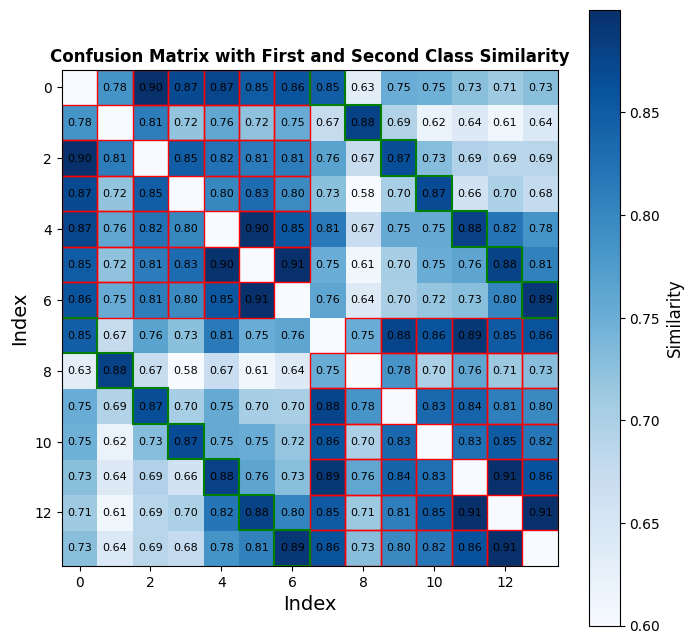

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# 임의의 유사도 행렬 생성 (가상의 데이터로 예시)
sim_mix0_mix0 = z_mix_eos @ z_mix_eos.T

# 첫 번째 클래스가 같은 항들의 유사도 추출
first_class_indices =  torch.cat([torch.triu_indices(7, 7, 1),torch.triu_indices(7, 7, 1) + 7],dim=1)
first_class_similarity = torch.cat([
    sim_mix0_mix0[first_class_indices[0], first_class_indices[1]],
    sim_mix0_mix0[first_class_indices[1], first_class_indices[0]],
])

# 두 번째 클래스가 같은 항들의 유사도 추출
second_class_indices = (torch.arange(7), torch.arange(7) + 7)
second_class_similarity = torch.cat([
    sim_mix0_mix0[second_class_indices[0], second_class_indices[1]],
    sim_mix0_mix0[second_class_indices[1], second_class_indices[0]]
])

# Confusion Matrix 초기화
confusion_matrix = torch.zeros(14, 14).to(torch_device)

# 첫 번째 클래스 유사도 값 반영
confusion_matrix[first_class_indices[0], first_class_indices[1]] = first_class_similarity[:len(first_class_similarity)//2]
confusion_matrix[first_class_indices[1], first_class_indices[0]] = first_class_similarity[len(first_class_similarity)//2:]

# 두 번째 클래스 유사도 값 반영
confusion_matrix[second_class_indices[0], second_class_indices[1]] = second_class_similarity[:len(second_class_similarity)//2]
confusion_matrix[second_class_indices[1], second_class_indices[0]] = second_class_similarity[len(second_class_similarity)//2:]

all_indices = torch.triu_indices(14, 14, 1)
all_pairs = set(zip(all_indices[0].tolist(), all_indices[1].tolist())) | set(zip(all_indices[1].tolist(), all_indices[0].tolist()))

# 첫 번째 클래스나 두 번째 클래스에 속하지 않는 인덱스 추출
excluded_indices = set(zip(first_class_indices[0].tolist(), first_class_indices[1].tolist())) | \
                   set(zip(first_class_indices[1].tolist(), first_class_indices[0].tolist())) | \
                   set(zip(second_class_indices[0].tolist(), second_class_indices[1].tolist())) | \
                   set(zip(torch.arange(14).tolist(), torch.arange(14).tolist())) | \
                   set(zip(second_class_indices[1].tolist(), second_class_indices[0].tolist()))


# 나머지 인덱스들을 필터링하여 추출 (대각선 요소도 포함)
other_pairs = all_pairs - excluded_indices
other_indices = (torch.tensor([i for i, j in other_pairs]), torch.tensor([j for i, j in other_pairs]))

# 나머지 인덱스들의 유사도 추출
other_similarity = sim_mix0_mix0[other_indices[0], other_indices[1]]
confusion_matrix[other_indices[0], other_indices[1]] = other_similarity
confusion_matrix[other_indices[1], other_indices[0]] = other_similarity


# 시각화
norm = mcolors.TwoSlopeNorm(vmin=0.6, vcenter=0.75, vmax=0.9)
plt.figure(figsize=(8, 8))
plt.imshow(confusion_matrix.cpu().detach().numpy(), cmap='Blues', interpolation='nearest', norm=norm)

# 첫 번째 클래스 영역에 테두리 추가
for i, j in zip(first_class_indices[0].cpu().detach().numpy(), first_class_indices[1].cpu().numpy()):
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
for i, j in zip(first_class_indices[1].cpu().detach().numpy(), first_class_indices[0].cpu().numpy()):
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)


# 두 번째 클래스 영역에 테두리 추가
for i, j in zip(second_class_indices[0].cpu().detach().numpy(), second_class_indices[1].cpu().numpy()):
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1.5, edgecolor='green', facecolor='none')
    plt.gca().add_patch(rect)
for i, j in zip(second_class_indices[1].cpu().detach().numpy(), second_class_indices[0].cpu().numpy()):
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=1.5, edgecolor='green', facecolor='none')
    plt.gca().add_patch(rect)


# Add color bar with labels
cbar = plt.colorbar()
cbar.set_label('Similarity', fontsize=12)

# Annotate matrix with values
for (i, j), val in np.ndenumerate(confusion_matrix.cpu().detach().numpy()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)

plt.title('Confusion Matrix with First and Second Class Similarity', fontsize=12, weight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Index', fontsize=14)
plt.grid(False)

# Display the plot
plt.show()


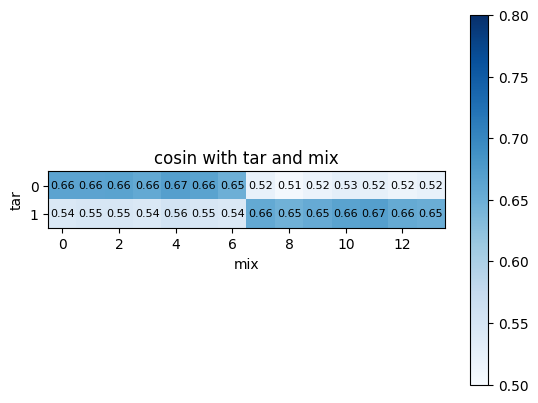

In [6]:
import matplotlib.pyplot as plt
import numpy as np
sim_tar_mix = z_tar_eos @ z_mix_eos.T

norm = mcolors.TwoSlopeNorm(vmin=0.5, vcenter=0.65, vmax=0.8)
plt.imshow(sim_tar_mix.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_tar_mix.cpu().detach().numpy()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)
plt.colorbar()

plt.title('cosin with tar and mix')
plt.xlabel('mix')
plt.ylabel('tar')
plt.show()

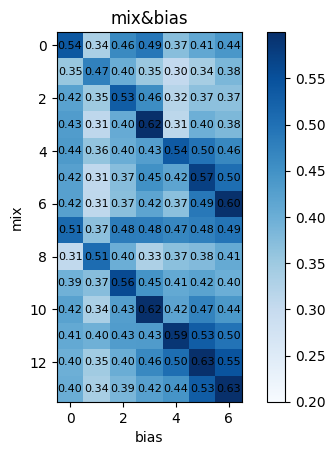

In [7]:
import matplotlib.pyplot as plt
import numpy as np

sim_mix_bias = z_mix_eos @ z0_bias_eos.T
norm = mcolors.TwoSlopeNorm(vmin=0.2, vcenter=0.4, vmax=0.6)
plt.imshow(sim_mix_bias.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_mix_bias.cpu().detach().numpy()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)
plt.colorbar()

plt.title('mix&bias')
plt.xlabel('bias')
plt.ylabel('mix')
plt.show()

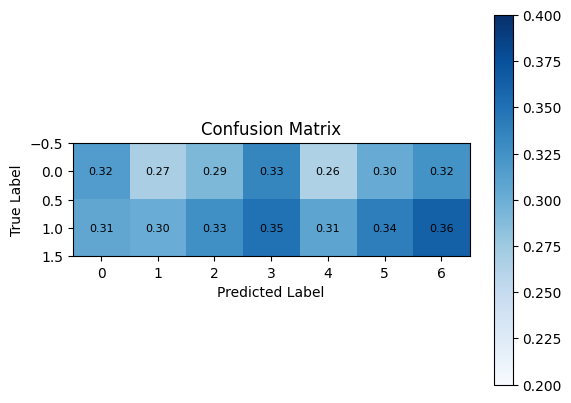

In [8]:
import matplotlib.pyplot as plt
import numpy as np

sim_mix_bias = z_tar_eos @ z0_bias_eos.T

norm = mcolors.TwoSlopeNorm(vmin=0.2, vcenter=0.3, vmax=0.4)
plt.imshow(sim_mix_bias.cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.Blues, norm=norm)
for (i, j), val in np.ndenumerate(sim_mix_bias.cpu().detach().numpy()):
    if val != 0:
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()